## 5/1/19

### *m4.xlarge* instance
The m4.xlarge instances have 4 vCPUs, 16GiB memory, and 32 GiB of EBS storage. The following information contain the architecture of the instance, the number of vCPUs, threads per vCPU/core, the processor, and the cache sizes:<br>
`Architecture:          x86_64
CPU(s):                4
On-line CPU(s) list:   0-3
Thread(s) per core:    2
Core(s) per socket:    2
Socket(s):             1
Model name:            Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              46080K`

Need to run `export PYSPARK_PYTHON=python3.5` (for stand-alone instance) or `export PYSPARK_PYTHON=python3.4` (for cluster) in commandline to use python3.4 as default python for Spark Cluster. Spark cluster already has `numpy` and `scipy`.

### Testing sequential code on stand alone *m4.xlarge* instance using Python 3.5
12min and 54seconds to run sequential pipeline with *control_file_100_seqs.txt* and *experimental_file_100_seqs.txt* input files. Both of these input file were constructed with 75 perfect matching reads and 25 that required ED calculation. About 12 of the ED sequencing reads come in the first 50 lines of each input file to split them up evenly.

Output matches the output I got on my own machine.

### Testing spark code on stand alone *m4.xlarge* instance using Python 3.5 and Spark local mode

I have written the Spark application in the file `spark_implementation.py`.

To run the `spark_implementation.py` code on the input files *control_file_100_seqs.txt* and *experimental_file_100_seqs.txt* using 2, 3 or 4 cores on a single *m4.xlarge* instance, I modified my `spark_implementation.py` code by including a `[c]` (where $c=2,3,4$) in the code at `SparkConf().setMaster('local[c]')`. 

I used the following command to run my tests:<br>
`spark-submit spark_implementation_local.py -u control_file_100_seqs.txt -s experimental_file_100_seqs.txt -g Brie_CRISPR_library_with_control_guides.csv -o spark_run_1_core`.

The table below lists the number of cores used in local mode, the elapsed time, and the speed-up when I use 2, 3 or 4 cores.

|Number of cores| Elapsed time |Speed-up|
|---------------|--------------|--------|
|1 |  685 sec | -|
|2 |  352 sec |1.94x|
|3 |  sec ||
|4 |  sec ||

### Why does local mode with 3 or 4 threads specified only give me two tasks?

### Testing spark code on Spark Cluster of m4.xlarge instances

To tune the number of tasks/partitions the input files should be broken up into, I changed the Spark application to be able to take in a user-defined variable for the number of partitions the input files should be split into through command-line; the flag `-n` allows the user to define the number of partitions. This application is saved as `spark_implementation_distributed.py`. Within this application/code, I changed the number of partitions for Spark by adding an argument in `sc.textFile("control_file_100_seqs.txt", n)` where `n` is the number of partitions specified by the user through the `-n` flag.

The table below shows my efforts to tune different parameters to improve the speed-up when using up to 8 nodes. The speed-up is compared to the performance of 1 core on 1 node of a m4.xlarge instances. 

I ran the following command:<br>
`spark-submit --num-executors 2 --executor-cores 2 spark_implementation_distributed.py -u control_file_100_seqs.txt -s experimental_file_100_seqs.txt -g Brie_CRISPR_library_with_control_guides.csv -o spark_run_4_core -n 4`


|Number of worker nodes| Number of cores|Number of tasks| Elapsed time |Speed-up|
|---------------|--------------|--------------|--------|--------------|
|2 | 2 | 4 |  439 sec | 1.56x|
|2 | 2 | 32 |  249 sec | 2.75x|
|2 | 2 | 50 |  243 sec | 2.82x|
|4 | 2 | 32 |   144 sec | 4.76x|
|4 | 2 | 50 |   148 sec | 4.63x|
|8 | 2 | 32 |   139 sec | 4.93x|
|8 | 2 | 50 |  81 sec |8.46x|
|8 | 2 | 75 |   106 sec |6.46x|


From this table, we generally see that more cores and more tasks give better performance. Interestingly, with 8 nodes and using 2 cores on each node, for a total of 16 threads, the performance is about equivalent to using 4 instances with 2 cores each. This is most likely because the 32 tasks on the 8 nodes causes load-balancing issues where one or two nodes get slowed down by too many edit distance calculations. Once we increase the number of tasks/partitions to 50, we see that we get ~8.5x speed-up. For these input files of 100 sequencing reads each, 75 tasks/partitions introduces more synchronization and communication overhead for Spark resulting in lower performance than the run with 50 tasks.

**Cost of cluster**<br>
\\$0.20 per m4.xlarge instance hour<br>
\\$0.06 per hour of EMR


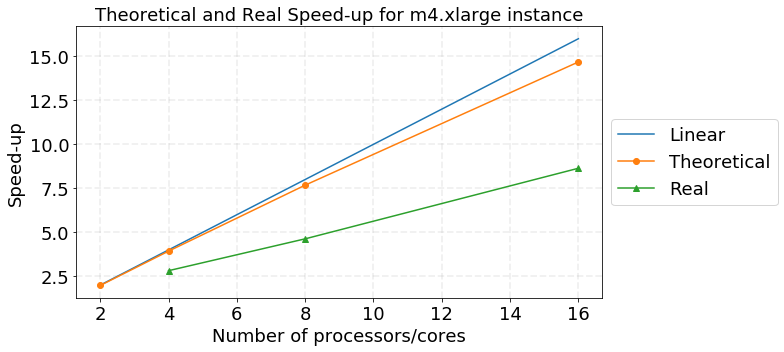

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# make graph of speed up compared to theoretical speed up
nprocessors = [2, 4, 8, 16];
strong_scaling_perf = [1.98,3.93, 7.68, 14.68]; #theoretical values for strong scaling for fixed problem size

real_nprocessors = [4,8,16];
real_scaling = [2.82, 4.63, 8.64];

# make the figure
fig = plt.figure(figsize = (11,5));
ax = plt.subplot(1,1,1);
f_size = 18; # font size

# adjust size of tickmarks in axes
ax.tick_params(labelsize = f_size)

# adjust size of axis label
ax.set_xlabel('Number of processors/cores', fontsize = f_size)
ax.set_ylabel('Speed-up', fontsize = f_size)

# set figure title label
ax.set_title("Theoretical and Real Speed-up for m4.xlarge instance", fontsize = f_size)

# set up grid with this 
ax.grid(True, lw=1.75, ls='--', alpha=0.2)

# make actual plot
ax.plot([2,4,8,16], [2,4,8,16], '-', label='Linear')
ax.plot(nprocessors, strong_scaling_perf, "-o", label="Theoretical");
ax.plot(real_nprocessors, real_scaling,"-^", label="Real");
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = f_size);
# plt.show();
plt.tight_layout()
plt.savefig('Theoretical and Real Speed-up.jpg', dpi=300, )

The real speed-up we achieve is lower than the theoretical speed-up calculated using Amdahl's Law for a fixed problem size. As we increase the number of processors, the real speed-up does not follow the close-to-linear trend that was theoretically calculated. This is likely due to increased overhead due to data management and movement caused by using more cores and smaller partitions.

Since we do not know which sequences from our input files we will need to perform edit distance calculations for, it is probably best to separate the input file into as many partitions as possible because this will spread out the sequences that require edit distance calculations over as many cores as possible. As seen above, there is a performance-overhead trade-off when using more and more partitions. Using a few instances with many cores may prove to be better than using many instances that each have a couple of cores.

### 1000seq input files
We scaled up the input files by 10x by making each input file 1000 sequence reads; each file contains 750 sequence reads that perfectly match one of the 80,000 guides and 250 sequence reads that require edit distance calculation. These files are called *control_file_1000_seqs.txt* and *experimental_file_1000_seqs.txt*. Even using two 1000 sequence read files is only $0.01$% of our data.

If we were to run these input files on a single m4.xlarge instance using 1 core, we calculate that this would take
$$
\left(\dfrac{685\text{sec}}{200\text{sequences}}\right) \cdot 2000\text{sequences} = 6,850 \text{sec} = 1.90\text{hrs}
$$

Below is a table of the performance of multiple *m4.xlarge* instances on these 1000 sequence input files. The speed-up is calculated against our calculation of how long it would take to process this data on one core of a *m4.xlarge* instance.

|Number of worker nodes| Number of cores|Number of tasks| Elapsed time |Speed-up|
|---------------|--------------|--------------|--------|--------------|
|8 | 2 | 50 |  699 sec | 9.79x|
|8 | 2 | 100 |   634 sec |10.8x|
|8 | 2 | 500 |    600 sec |11.4x|


### Test with c4.8xlarge instance

Information about c4.8xlarge instances: <br>
`Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                36
On-line CPU(s) list:   0-35
Thread(s) per core:    2
Core(s) per socket:    9
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Model name:            Intel(R) Xeon(R) CPU E5-2666 v3 @ 2.90GHz
Stepping:              2
CPU MHz:               1635.441
CPU max MHz:           3500.0000
CPU min MHz:           1200.0000
BogoMIPS:              5800.17
Hypervisor vendor:     Xen
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              25600K`<br>

From this information, we only really have 18 cores available to use, so this is the number of executor cores, I will pass to `spark-submit`. I will test this on a cluster with 1 master node and 4 worker nodes.

I ran the following command:<br>
`spark-submit --num-executors 4 --executor-cores 18 spark_implementation_distributed.py -u Genome-Pos-3T3-Unsorted_1000_seqs.txt -s Genome-Pos-3T3-Bot10_1000_seqs.txt -g Brie_CRISPR_library_with_control_guides.csv -o spark_run_4_core -n 250`


|Number of worker nodes| Number of cores|Number of tasks| Elapsed time |Speed-up|
|---------------|--------------|--------------|--------|--------------|
|4 | 18 | 250 |   sec | x|
|4 | 18 | 500 |   sec | x|

### Test with m4.10xlarge instance

Information about m4.10xlarge instances: <br>
`Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    2
Core(s) per socket:    10
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Model name:            Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz
Stepping:              2
CPU MHz:               2142.562
CPU max MHz:           3000.0000
CPU min MHz:           1200.0000
BogoMIPS:              4800.07
Hypervisor vendor:     Xen
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              30720K`

From this information, we only really have 20 cores available to use, so this is the number of executor cores, I will pass to spark-submit. I will test this on a cluster with 1 master node and 4 worker nodes.

I ran the following command:<br>
`spark-submit --num-executors 4 --executor-cores 20 spark_implementation_distributed.py -u control_file_1000_seqs.txt -s experimental_file_1000_seqs.txt -g Brie_CRISPR_library_with_control_guides.csv -o spark_run_4_core -n 250`.

The speed-up is calculated against our calculation of how long it would take to process this data on one core of a m4.xlarge instance.

|Number of worker nodes| Number of cores|Number of tasks| Elapsed time |Speed-up|
|---------------|--------------|--------------|--------|--------------|
|4 | 20 | 250 |  191 sec | 35.9x|
|4 | 40 | 250 |   185 sec | 37x|
|4 | 20 | 500 |   160 sec | 42.8x|
|4 | 20 | 750 |    159 sec | 43.1x|

Even though the *m4.10xlarge* instances offer 40 vCPUs, the speed-up by specifying 20 cores versus 40 cores when using 250 tasks is not very different, indicating that the user is really only getting 20 threads.

### Test with m4.16xlarge instance

Information about m4.16xlarge instances: <br>
`Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                64
On-line CPU(s) list:   0-63
Thread(s) per core:    2
Core(s) per socket:    16
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
Stepping:              1
CPU MHz:               1831.914
CPU max MHz:           3000.0000
CPU min MHz:           1200.0000
BogoMIPS:              4600.12
Hypervisor vendor:     Xen
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              46080K`

From this information, we only really have 32 cores available to use, so this is the number of executor cores, I will pass to spark-submit. I will test this on a cluster with 1 master node and 4 worker nodes.

I ran the following command:<br>
`spark-submit --num-executors 4 --executor-cores 32 spark_implementation_distributed.py -u control_file_1000_seqs.txt -s experimental_file_1000_seqs.txt -g Brie_CRISPR_library_with_control_guides.csv -o spark_run_4_core -n 250`.

The speed-up is calculated against our calculation of how long it would take to process this data on one core of a m4.xlarge instance.

|Number of worker nodes| Number of cores|Number of tasks| Elapsed time |Speed-up|
|---------------|--------------|--------------|--------|--------------|
|4 | 32 | 250 |  156 sec | 43.9x|
|4 | 64 | 250 |   150 sec | 45.7x|
|4 | 32 | 500 |   129 sec | 53.1x|
|4 | 32 | 500 |   123 sec | 55.7x|


In [ ]:
# grap

### Future directions
1. Allow user to specify where input files are in an S3 bucket. Currently, this would require more configuration in the Spark application to take in a user's private key in addition to the path to the input files, thus we did not implement this now.
2. Test the use of GPUs for calculating edit distance 80,000 times for a sequence. Due to the difficulty of configuring a Spark cluster to run with GPU instances (installation of CUDA and OpenACC on each worker node), we did not try to implement this. This would require extra overhead as well because of memory movement to/from GPU; NVIDIA Tesla K80 has about 5000 cores, so we would have to perform at least 16 read and write operations to/from GPU memory to calculate the edit distances for a single sequence.